# Analyse full screening answers

This notebook has the purpose to
- clean and prepare the data coming from the MS forms sheet
- visualize and aggregate the research questions
- further analyse the dataset

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# # for printing issues
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199

In [3]:
# read in dataframe
df = pd.read_excel('..\data\Full Screening Questions (1-621)_reviewed.xlsx')

# strip strings in object columns
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

# check for multiple answers on the same paper
df = df.drop_duplicates(subset=['Number - Author Year'], keep='first')

print('df shape is ',df.shape)

df shape is  (610, 12)


## Clean and Prepare

In [4]:
# remove \n from strings
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

## How many papers have to be excluded for which reason?

In [5]:
df[df['Concrete medical supervised Machine Learning usecase?']=='No -> Exclude from review and submit form'].shape[0]

87

In [6]:
df[df['Which XAI method is used?']=='None -> Exclude from review and submit form;'].shape[0]

64

In [7]:
df[df['Tabular or Image data as input?']=='Text-> Exclude from review and submit form'].shape[0]

13

In [8]:
df[df['Tabular or Image data as input?']=='Audio-> Exclude from review and submit form'].shape[0]

0

In [9]:
# drop papers that have been excluded due to at least one of the following reasons
# - No concrete supervised medical machine learning use case
df = df[df['Concrete medical supervised Machine Learning usecase?']!='No -> Exclude from review and submit form']
# - No XAI method provided
df = df[df['Which XAI method is used?']!='None -> Exclude from review and submit form;']
# - No image or tabular data as input
df = df[df['Tabular or Image data as input?']!='Text-> Exclude from review and submit form']
df = df[df['Tabular or Image data as input?']!='Audio-> Exclude from review and submit form']

In [10]:
# check for missing values
authors_list = []
for row in df.index:
    df_row = df.loc[row, :]
    
    if pd.isnull(df_row).any():
        authors_list.append(df.loc[row, 'Number - Author Year'])

authors_list = list(set(authors_list))
sorted(authors_list)

[]

In [11]:
print('After dropping excluded papers, df shape is ',df.shape)

After dropping excluded papers, df shape is  (450, 12)


No missing values left - continue with granularisation of columns - "unroll" columns.

In [12]:
"""
# divide column 'Which XAI method is used?' into multiple columns:
df[['XAI_method_1', 'XAI_method_2', 'XAI_method_3', 'XAI_method_4', 'XAI_method_5']] = df['Which XAI method is used?'].str.split(";", expand = True)

# Problem: if "own method" is selected, now the description of this method might be in the next column
#'XAI_method_5' could be deleted again, because contains no information - only None values
"""

def used_methods_value_count(df):
    """Performs a value count on which method is used? Excludes own developed methods"""
    
    # drop all rows with substring "Own method developed"
    df = df[~df['Which XAI method is used?'].str.contains('Own method developed')]

    # Perform value counts on remaining methods
    ser = df['Which XAI method is used?'].str.split(";", expand=True).stack(dropna=True).value_counts()
    
    # drop the first line as this is a value counts of None
    ser = ser.drop(labels=[''])
    
    # alter index for better readability
    ser.rename(index={'Model is intrinsic interpretable (i.e., decision tree or linear regression)':'Intrinsic interpretable'},
              inplace=True)
    
    return ser

ser = used_methods_value_count(df)

print('Top 20 most used XAI methods')
ser[:20]

Top 20 most used XAI methods


SHAP                                                                         119
Intrinsic interpretable                                                       94
Class Activation Mapping or related (i. e., Grad-CAM)                         92
Random Forest Feature Importance                                              46
LIME                                                                          40
Partial Dependence Plots                                                      14
Layer-Wise Relevance Propagation                                               9
Permutation Importance                                                         5
DeepLift                                                                       3
Saliency Maps                                                                  3
Attention Mechanism                                                            3
GSInquire                                                                      2
Post-Hoc Decision Tree      

In [13]:
# How many methods in total that are not self-developed?
ser.sum()

490

In [14]:
# How many self developed methods?
ser['Own method developed'] = df['Which XAI method is used?'].str.contains('Own method developed').sum()
ser = ser.sort_values(ascending=False)
ser['Own method developed']

45

In [15]:
# How many explanations methods per paper on average?
ser.sum()/df.shape[0]

1.1888888888888889

## Which XAI methods have been used the most?

In [16]:
# Explanation methods by data input
df_tab = df[df['Tabular or Image data as input?']=='Tabular (includes EEG, ECG, time-series data)']
df_img = df[df['Tabular or Image data as input?']=='Image data (includes video data)']

ser_tab = used_methods_value_count(df_tab).rename('tabular')
ser_img = used_methods_value_count(df_img).rename('image')

df_tab_img = pd.concat([ser_tab, ser_img], 
                       names=['tabular', 'image'], 
                       axis='columns')

# replace NaNs
df_tab_img=df_tab_img.fillna(0)

# drop methods that have been used less than 3 times
df_tab_img = df_tab_img[(df_tab_img.tabular>2) | (df_tab_img.image>2)]

df_tab_img

,tabular,image
SHAP,108.0,11.0
Intrinsic interpretable,90.0,4.0
Random Forest Feature Importance,41.0,5.0
LIME,27.0,13.0
Partial Dependence Plots,14.0,0.0
"Class Activation Mapping or related (i. e., Grad-CAM)",8.0,84.0
Permutation Importance,5.0,0.0
Layer-Wise Relevance Propagation,3.0,6.0
Saliency Maps,0.0,3.0


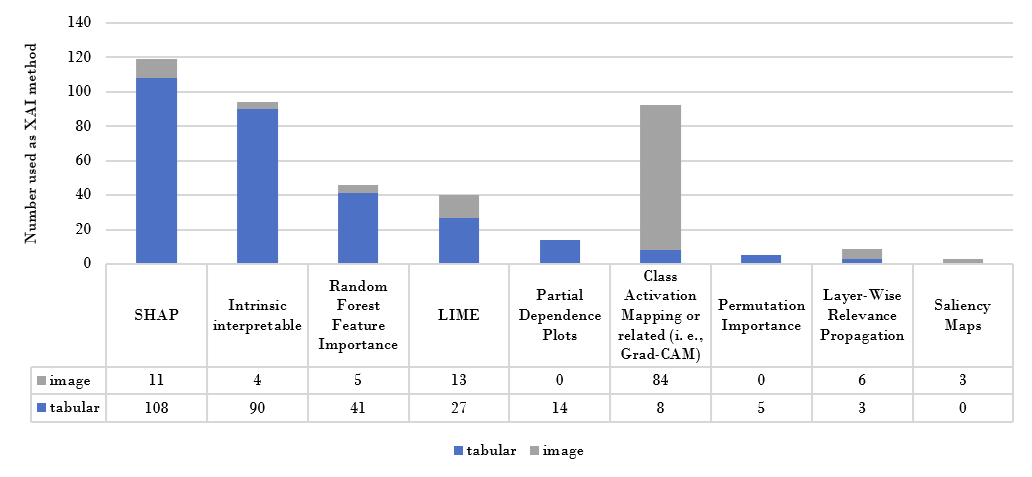

## Which data input type is more common?

In [17]:
df['Tabular or Image data as input?'].value_counts()

Tabular (includes EEG, ECG, time-series data)    307
Image data (includes video data)                 143
Name: Tabular or Image data as input?, dtype: int64